# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.

**Important Notes**:
1. Be sure to **document** all of your decisions, as well as your intermediate and final results. Make sure your conclusions and analyses are clearly presented. Don't make us dig into your code or walls of printed results to try to draw conclusions from your code.
2. If you use code from someone else (e.g. Github, Stack Overflow, ChatGPT, etc) you **must be transparent about it**. Document your sources and explain how you adapted any partial solutions to creat **your** solution.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Preface: Some code to get you started

What follows is some **very simple** code for training an MLP on MNIST. The point of this code is to get you up and running (and to verify that your Python environment has all needed dependencies).

**Note**: As you read through my code and execute it, this would be a good time to think about *abstracting* **your** model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

In [ ]:
%%script false --no-raise-error
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

#### Data preparation

Here is some basic dataset loading, validation splitting code to get you started working with MNIST.

In [ ]:
%%script false --no-raise-error
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

#(ds_train.dataset.data/255.0).mean() = 0.1307
#(ds_train.dataset.data/255.0).std() = 0.3081
#why exactly 0.1307 and 0.3081?

# Load MNIST train and test.
ds_train = MNIST(root='./data', train=True, download=True, transform=transform)
ds_test = MNIST(root='./data', train=False, download=True, transform=transform)

# Split train into train and validation.
val_size = 5000
I = np.random.permutation(len(ds_train))
ds_val = Subset(ds_train, I[:val_size])
ds_train = Subset(ds_train, I[val_size:])

#### Boilerplate training and evaluation code

This is some **very** rough training, evaluation, and plotting code. Again, just to get you started. I will be *very* disappointed if any of this code makes it into your final submission.

In [ ]:
%%script false --no-raise-error
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report

# Function to train a model for a single epoch over the data loader.
def train_epoch(model, dl, opt, epoch='Unknown', device='cpu'):
    model.train()
    losses = []
    for (xs, ys) in tqdm(dl, desc=f'Training epoch {epoch}', leave=True):
        xs = xs.to(device)
        ys = ys.to(device)
        opt.zero_grad()
        logits = model(xs)
        loss = F.cross_entropy(logits, ys)
        loss.backward()
        opt.step()
        losses.append(loss.item())
    return np.mean(losses)

# Function to evaluate model over all samples in the data loader.
def evaluate_model(model, dl, device='cpu'):
    model.eval()
    predictions = []
    gts = []
    for (xs, ys) in tqdm(dl, desc='Evaluating', leave=False):
        xs = xs.to(device)
        preds = torch.argmax(model(xs), dim=1)
        gts.append(ys)
        predictions.append(preds.detach().cpu().numpy())
        
    # Return accuracy score and classification report.
    return (accuracy_score(np.hstack(gts), np.hstack(predictions)),
            classification_report(np.hstack(gts), np.hstack(predictions), zero_division=0, digits=3))

# Simple function to plot the loss curve and validation accuracy.
def plot_validation_curves(losses_and_accs):
    losses = [x for (x, _) in losses_and_accs]
    accs = [x for (_, x) in losses_and_accs]
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Average Training Loss per Epoch')
    plt.subplot(1, 2, 2)
    plt.plot(accs)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title(f'Best Accuracy = {np.max(accs)} @ epoch {np.argmax(accs)}')

#### A basic, parameterized MLP

This is a very basic implementation of a Multilayer Perceptron. Don't waste too much time trying to figure out how it works -- the important detail is that it allows you to pass in a list of input, hidden layer, and output *widths*. **Your** implementation should also support this for the exercises to come.

In [ ]:
%%script false --no-raise-error
class MLP(nn.Module):
    def __init__(self, layer_sizes):
        super().__init__()
        #nn.ModuleList è fondamentale perchè in caso di tanti layers, il garbage collector potrebbe pensare bene di buttare quelli poco usati
        self.layers = nn.ModuleList([nn.Linear(nin, nout) for (nin, nout) in zip(layer_sizes[:-1], layer_sizes[1:])])
    
    def forward(self, x):
        return reduce(lambda f, g: lambda x: g(F.relu(f(x))), self.layers, lambda x: x.flatten(1))(x)

#### A *very* minimal training pipeline.

Here is some basic training and evaluation code to get you started.

**Important**: I cannot stress enough that this is a **terrible** example of how to implement a training pipeline. You can do better!

In [ ]:
%%script false --no-raise-error
# Training hyperparameters.
device = 'cpu' #'cuda' if torch.cuda.is_available else 'cpu'
epochs = 30
lr = 0.01
batch_size = 512

# Architecture hyperparameters.
input_size = 28*28
#width = 16
#depth = 2

# Dataloaders.
dl_train = torch.utils.data.DataLoader(ds_train, batch_size, shuffle=True, num_workers=4)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size, num_workers=4)
dl_test  = torch.utils.data.DataLoader(ds_test, batch_size, shuffle=True, num_workers=4)

# Instantiate model and optimizer.
model_mlp = MLP([input_size] + [256,128,10]).to(device)#[width]*depth + [10]).to(device)
opt = torch.optim.Adam(params=model_mlp.parameters(), lr=lr)

# Training loop.
losses_and_accs = []
for epoch in range(epochs):
    loss = train_epoch(model_mlp, dl_train, opt, epoch, device=device)
    (val_acc, _) = evaluate_model(model_mlp, dl_val, device=device)
    losses_and_accs.append((loss, val_acc))

# And finally plot the curves.
plot_validation_curves(losses_and_accs)
print(f'Accuracy report on TEST:\n {evaluate_model(model_mlp, dl_test, device=device)[1]}')

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

In [1]:
##################### GENERAL IMPORTS #####################

import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
import time
import copy

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, Subset
import torchvision
from torchvision import transforms
from torchvision.models.resnet import BasicBlock, Bottleneck

from tqdm.auto import tqdm
import inspect
import numpy as np
import math
import random

/home/roccotescaro/miniconda3/envs/DRL/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
################## LOVE DETERMINISM ##################

SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
torch.use_deterministic_algorithms(True)
torch.backends.cudnn.deterministic = True

In [3]:
################### SOME HYPERPARAMETERS ###################

data_dir = './data'
checkpoints_dir = './checkpoints'
log_dir = './logs'

batch_size = 128
num_workers = 4
lr = 1.e-3
patience = 3
n_epochs = 30

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [4]:
############## TENSORBOARD VISUALIZATION ################

%load_ext tensorboard
%tensorboard --logdir=./logs

Reusing TensorBoard on port 6006 (pid 98175), started 1 day, 0:00:04 ago. (Use '!kill 98175' to kill it.)

In [ ]:
################ CLEARING STUFF ################

import shutil

def clear(_dir):
    if os.path.exists(_dir):
        if os.path.isdir(_dir):
            shutil.rmtree(_dir)
        os.makedirs(_dir, exist_ok = True)

#clear(data_dir)
#clear(checkpoints_dir)
#clear(log_dir)

In [ ]:
############### IMPORTING MY STUFF ###################

from SLTrainingPipeline import SLTrainingPipeline
from MLP import MLP, ResMLP
from CNN import CNN, ResCNN

In [ ]:
########### CALLBACKS AND METRICS FOR TRAINING PIPELINE ###########

def log_gradients_trend(pipeline, **context):
    #exit the callback if we do not want to log or if we are in evaluation phase
    if not context.get("is_training", False) or not pipeline.writer: 
        return
        
    log_every_n = 32 #should probably be a parameter and not hardcoded but still...

    writer = pipeline.writer
    model = pipeline.model
    run_id = pipeline.run_id
    batch_size = context.get("batch_size", 64) #again giving a default value to batch_size not that great but pipeline should always provide this

    global_step = pipeline.current_epoch * batch_size + pipeline.current_batch
    
    if global_step % log_every_n != 0:
        return
    
    parameters = [(i, name, param) for i, (name, param) in enumerate(model.named_parameters())
                 if param.requires_grad and param.grad is not None and "bias" not in name]
    
    if not parameters: #probably not needed, but checking the pipeline model is something that makes sense
        return
        
    first_idx, first_name, first_param = parameters[0]
    last_idx, last_name, last_param = parameters[-1]
    
    first_grad_magnitude = torch.norm(first_param.grad).item()
    last_grad_magnitude = torch.norm(last_param.grad).item()
    
    writer.add_scalar(
        tag = f"grad_first_layer/{run_id}",
        scalar_value = first_grad_magnitude,
        global_step = global_step
    )
    
    writer.add_scalar(
        tag = f"grad_last_layer/{run_id}", 
        scalar_value = last_grad_magnitude,
        global_step = global_step
    )
    
    if first_grad_magnitude > 0:
        grad_ratio = last_grad_magnitude / first_grad_magnitude
        writer.add_scalar(
            tag = f"grad_last_to_first_ratio/{run_id}",
            scalar_value = grad_ratio,
            global_step = global_step
        )
    
    writer.flush()

def monitor_weights_change(pipeline, **context):
    if not context.get('is_training', False) or pipeline.current_batch != 0:
        return

    epoch = pipeline.current_epoch
    if epoch == 0:
        #store initial weights
        pipeline.callbacks_data['initial_weights'] = {}
        for name, param in pipeline.model.named_parameters():
            pipeline.callbacks_data['initial_weights'][name] = param.data.clone().mean().item()
    elif epoch == 1:
        #compare with weights after first epoch
        print("Weight changes after first epoch:")
        for name, param in pipeline.model.named_parameters():
            initial = pipeline.callbacks_data['initial_weights'][name]
            current = param.data.mean().item()
            change = abs(current - initial)
            print(f"{name}: initial = {initial:.6f}, current = {current:.6f}, change = {change:.6f}")

gradient_callbacks = {
    #'on_batch_begin': [monitor_weights_change],
    'on_after_back': [log_gradients_trend] 
}

################ METRICS ####################

def accuracy(logits, targets):
    _, predicted = torch.max(logits.data, 1)
    return (predicted == targets).float().mean().item()

metrics = {"accuracy": accuracy}

In [ ]:
################ MINST #####################

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

split = [0.8, 0.1] #train val

train_val_dataset = torchvision.datasets.MNIST(root = data_dir, train = True, download = True, transform = transform)
test_dataset = torchvision.datasets.MNIST(root = data_dir, train = False, download = True, transform = transform)

train_size = int(split[0]/(split[0] + split[1]) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

train = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
val = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)


In [ ]:
############### TEST MLP CLASS ##################

model = MLP([28*28, 128, 64, 10], act_funcs = [nn.ReLU, nn.ReLU, None], use_batch_norm = True, dropouts = [0.2, 0.2, 0.0])

optimizer = optim.Adam(model.parameters(), lr = lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = patience)

pipeline = SLTrainingPipeline(
    model = model,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'test_mlp_class',
    checkpoint_dir = checkpoints_dir, #'../checkpoints', #for temp checkpoints
    log_dir = log_dir, 
    callbacks = gradient_callbacks
)

history = pipeline.fit(epochs = n_epochs, train_loader = train, val_loader = val, verbose = False)
#pipeline.load()

pipeline.plot()

### Exercise 1.2: Adding Residual Connections

Implement a variant of your parameterized MLP network to support **residual** connections. Your network should be defined as a composition of **residual MLP** blocks that have one or more linear layers and add a skip connection from the block input to the output of the final linear layer.

**Compare** the performance (in training/validation loss and test accuracy) of your MLP and ResidualMLP for a range of depths. Verify that deeper networks **with** residual connections are easier to train than a network of the same depth **without** residual connections.

**For extra style points**: See if you can explain by analyzing the gradient magnitudes on a single training batch *why* this is the case. 

In [ ]:
############### DEPTH COMPARISON #################

depths = [4, 8, 16, 32]
hidden_dim = 32
input_size = 28*28
output_size = 10

for d in depths:
    layer_sizes = [input_size] + [hidden_dim] * (d - 1) + [output_size]
    act_funcs = [nn.Sigmoid] * (d - 2) #use sigmoid up to last layer which will not have activation function (sigmoid suffer much more than relu vanishing gradient)
    init_funcs = nn.init.xavier_uniform_ #further highlight vanishing gradient

    mlp = MLP(
        layer_sizes,
        act_funcs = act_funcs, 
        init_funcs = init_funcs
    )

    optimizer = optim.Adam(mlp.parameters(), lr = lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = patience)

    pipeline = SLTrainingPipeline(
        model = mlp,
        optimizer = optimizer,
        lr_scheduler = scheduler,
        metrics = metrics,
        device = device,
        run_id = f'mlp_gradient_try_{d}',
        log_dir = log_dir, 
        callbacks = gradient_callbacks
    )

    history = pipeline.fit(
        epochs = n_epochs,
        train_loader = train,
        val_loader = val,
        verbose = False
    )

    results = pipeline.evaluate(test, verbose = True)

    
    #reinitialize mlp with same value, otherwise is like having a warmuped model
    resmlp = ResMLP( 
        layer_sizes = layer_sizes, 
        act_funcs = act_funcs,
        init_funcs = init_funcs,
        skip_connections = [(1, d - 2)]
    )

    optimizer = optim.Adam(resmlp.parameters(), lr = lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = patience)

    pipeline = SLTrainingPipeline(
        model = resmlp,
        optimizer = optimizer,
        lr_scheduler = scheduler,
        metrics = metrics,
        device = device,
        run_id = f'resmlp_gradient_try_{d}',
        log_dir = log_dir,
        callbacks = gradient_callbacks
    )

    history = pipeline.fit(
        epochs = n_epochs,
        train_loader = train,
        val_loader = val,
        verbose = False
    )

    results = pipeline.evaluate(test, verbose = True)

### Exercise 1.3: Rinse and Repeat (but with a CNN)

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR-10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Tip**: Feel free to reuse the ResNet building blocks defined in `torchvision.models.resnet` (e.g. [BasicBlock](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L59) which handles the cascade of 3x3 convolutions, skip connections, and optional downsampling). This is an excellent exercise in code diving. 

**Spoiler**: Depending on the optional exercises you plan to do below, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

In [11]:
################ CIFAR-10 ###################

#doing a bit of data augmentation on cifar10
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding = 4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

split = [0.8, 0.1] #train val

train_val_dataset = torchvision.datasets.CIFAR10(root = data_dir, train = True, download = True, transform = transform)
test_dataset = torchvision.datasets.CIFAR10(root = data_dir, train = False, download = True, transform = transform)

train_size = int(split[0]/(split[0] + split[1]) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(train_val_dataset, [train_size, val_size])

train = DataLoader(train_dataset, batch_size = batch_size, shuffle = False, num_workers = num_workers) #need to stay like that and not shuffle for ex. 2.2
val = DataLoader(val_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)
test = DataLoader(test_dataset, batch_size = batch_size, shuffle = True, num_workers = num_workers)


100%|██████████| 170M/170M [00:36<00:00, 4.73MB/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
############### DEPTH COMPARISON #################

input_shape = (3, 32, 32)
output_size = 10

depths = [6, 12, 20] # measured as number of convolutional layers
max_pool_layers = int(math.log(min(input_shape[1], input_shape[2]), 2) - 2) #could do up to -1 but it seems too much downsampling
chan_per_block = [64, 128, 256, 512]

def build_mlp_tail(cnn_output_size, output_size=10, hidden_dim=512):
     return MLP(
        layer_sizes = [cnn_output_size, hidden_dim, output_size],
        act_funcs = [nn.ReLU, None], #ReLU should suffer less of vanishing gradients
        dropouts = [0.5, 0.0],
        use_bias = True
    )

for i, d in enumerate(depths):
    architecture = []

    for block in range(max_pool_layers):
        num_conv = d // max_pool_layers if block != max_pool_layers - 1 else d - (max_pool_layers - 1) * (d // max_pool_layers)
        out_chan = chan_per_block[block]

        for conv in range(num_conv):
            layer_config = {
                "out_channels": out_chan,
                "kernel": 3,
                "stride": 1,
                "padding": 1,
                "use_batch_norm": True,
                "act_func": nn.ReLU
            }

            if conv == num_conv - 1:
                layer_config["pool"] = nn.MaxPool2d
                layer_config["pool_kernel"] = 2
                layer_config["pool_stride"] = 2
                layer_config["pool_padding"] = 0

            architecture.append(layer_config)

    cnn = CNN(input_shape, architecture)
    cnn_output_size = cnn.get_output_size()
    #print(cnn_output_size)
    mlp_tail_cnn = build_mlp_tail(cnn_output_size, output_size = output_size)
    cnn.attach_mlp(mlp_tail_cnn)

    optimizer_cnn = optim.Adam(cnn.parameters(), lr = lr)
    scheduler_cnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_cnn, mode = 'min', factor = 0.5, patience = patience)

    pipeline_cnn = SLTrainingPipeline(
        model = cnn,
        optimizer = optimizer_cnn,
        lr_scheduler = scheduler_cnn,
        metrics = metrics,
        device = device,
        run_id = f'cnn_{d}convs',
        log_dir = log_dir,
    )

    history_cnn = pipeline_cnn.fit(
        epochs = n_epochs,
        train_loader = train,
        val_loader = val,
        verbose = False
    )

    #results_cnn = pipeline_cnn.evaluate(test_loader, verbose = True)
    #results_summary[f'cnn_{depth_name}'] = results_cnn['test_accuracy']

    rescnn = ResCNN(input_shape, architecture)
    rescnn_output_size = rescnn.get_output_size()
    #print(rescnn_output_size)
    mlp_tail_rescnn = build_mlp_tail(rescnn_output_size, output_size=output_size)
    rescnn.attach_mlp(mlp_tail_rescnn)

    optimizer_rescnn = optim.Adam(rescnn.parameters(), lr = lr)
    scheduler_rescnn = optim.lr_scheduler.ReduceLROnPlateau(optimizer_rescnn, mode = 'min', factor = 0.5, patience = patience)

    pipeline_rescnn = SLTrainingPipeline(
        model = rescnn,
        optimizer = optimizer_rescnn,
        lr_scheduler = scheduler_rescnn,
        metrics = metrics,
        device = device,
        run_id = f'rescnn_{d}convs',
        log_dir = log_dir,
    )

    history_rescnn = pipeline_rescnn.fit(
        epochs = n_epochs,
        train_loader = train,
        val_loader = val,
        verbose = False # Set to False during loop
    )

    #results_rescnn = pipeline_rescnn.evaluate(test_loader, verbose = True)
    #results_summary[f'rescnn_{depth_name}'] = results_rescnn['test_accuracy']

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit. Each exercise is designed to require you to dig your hands **deep** into the guts of your models in order to do new and interesting things.

**Note**: These exercises are designed to use your small, custom CNNs and small datasets. This is to keep training times reasonable. If you have a decent GPU, feel free to use pretrained ResNets and larger datasets (e.g. the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset at 160px).

### Exercise 2.1: *Fine-tune* a pre-trained model
Train one of your residual CNN models from Exercise 1.3 on CIFAR-10. Then:
1. Use the pre-trained model as a **feature extractor** (i.e. to extract the feature activations of the layer input into the classifier) on CIFAR-100. Use a **classical** approach (e.g. Linear SVM, K-Nearest Neighbor, or Bayesian Generative Classifier) from scikit-learn to establish a **stable baseline** performance on CIFAR-100 using the features extracted using your CNN.
2. Fine-tune your CNN on the CIFAR-100 training set and compare with your stable baseline. Experiment with different strategies:
    - Unfreeze some of the earlier layers for fine-tuning.
    - Test different optimizers (Adam, SGD, etc.).

Each of these steps will require you to modify your model definition in some way. For 1, you will need to return the activations of the last fully-connected layer (or the global average pooling layer). For 2, you will need to replace the original, 10-class classifier with a new, randomly-initialized 100-class classifier.

In [ ]:
# Your code here.

### Exercise 2.2: *Distill* the knowledge from a large model into a smaller one
In this exercise you will see if you can derive a *small* model that performs comparably to a larger one on CIFAR-10. To do this, you will use [Knowledge Distillation](https://arxiv.org/abs/1503.02531):

> Geoffrey Hinton, Oriol Vinyals, and Jeff Dean. Distilling the Knowledge in a Neural Network, NeurIPS 2015.

To do this:
1. Train one of your best-performing CNNs on CIFAR-10 from Exercise 1.3 above. This will be your **teacher** model.
2. Define a *smaller* variant with about half the number of parameters (change the width and/or depth of the network). Train it on CIFAR-10 and verify that it performs *worse* than your **teacher**. This small network will be your **student** model.
3. Train the **student** using a combination of **hard labels** from the CIFAR-10 training set (cross entropy loss) and **soft labels** from predictions of the **teacher** (Kulback-Leibler loss between teacher and student).

Try to optimize training parameters in order to maximize the performance of the student. It should at least outperform the student trained only on hard labels in Setp 2.

**Tip**: You can save the predictions of the trained teacher network on the training set and adapt your dataloader to provide them together with hard labels. This will **greatly** speed up training compared to performing a forward pass through the teacher for each batch of training.

In [12]:
########## CALLBACKS TO SAVE SOFT LABELS DURING TEACHER EVALUATION ##############
#why on evaluation? we want to save logits of training set but we do not want to update
#the gradients while saving them, logits are obviously computeted at training time too
#but this way is just easier to setup with my class. We gonna pass training set at evaluation
#just to save them.


def activate_logits_saving(pipeline, **context):
    pipeline.callbacks_data["save_logits"] = True
    pipeline.callbacks_data["soft_labels"] = []


def save_logits(pipeline, **context):
    if context.get("is_training", True):
        return
        
    if not pipeline.callbacks_data.get("save_logits", False):
        return

    logits = context.get("logits")
    
    if logits is not None:
        pipeline.callbacks_data["soft_labels"].append(logits.detach().cpu())

callbacks = {
    "on_eval_begin": [activate_logits_saving],
    "on_batch_end": [save_logits]
}

/home/roccotescaro/repo/university/master/deep_learning_app/LAB/BaseTrainingPipeline.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(file_path, map

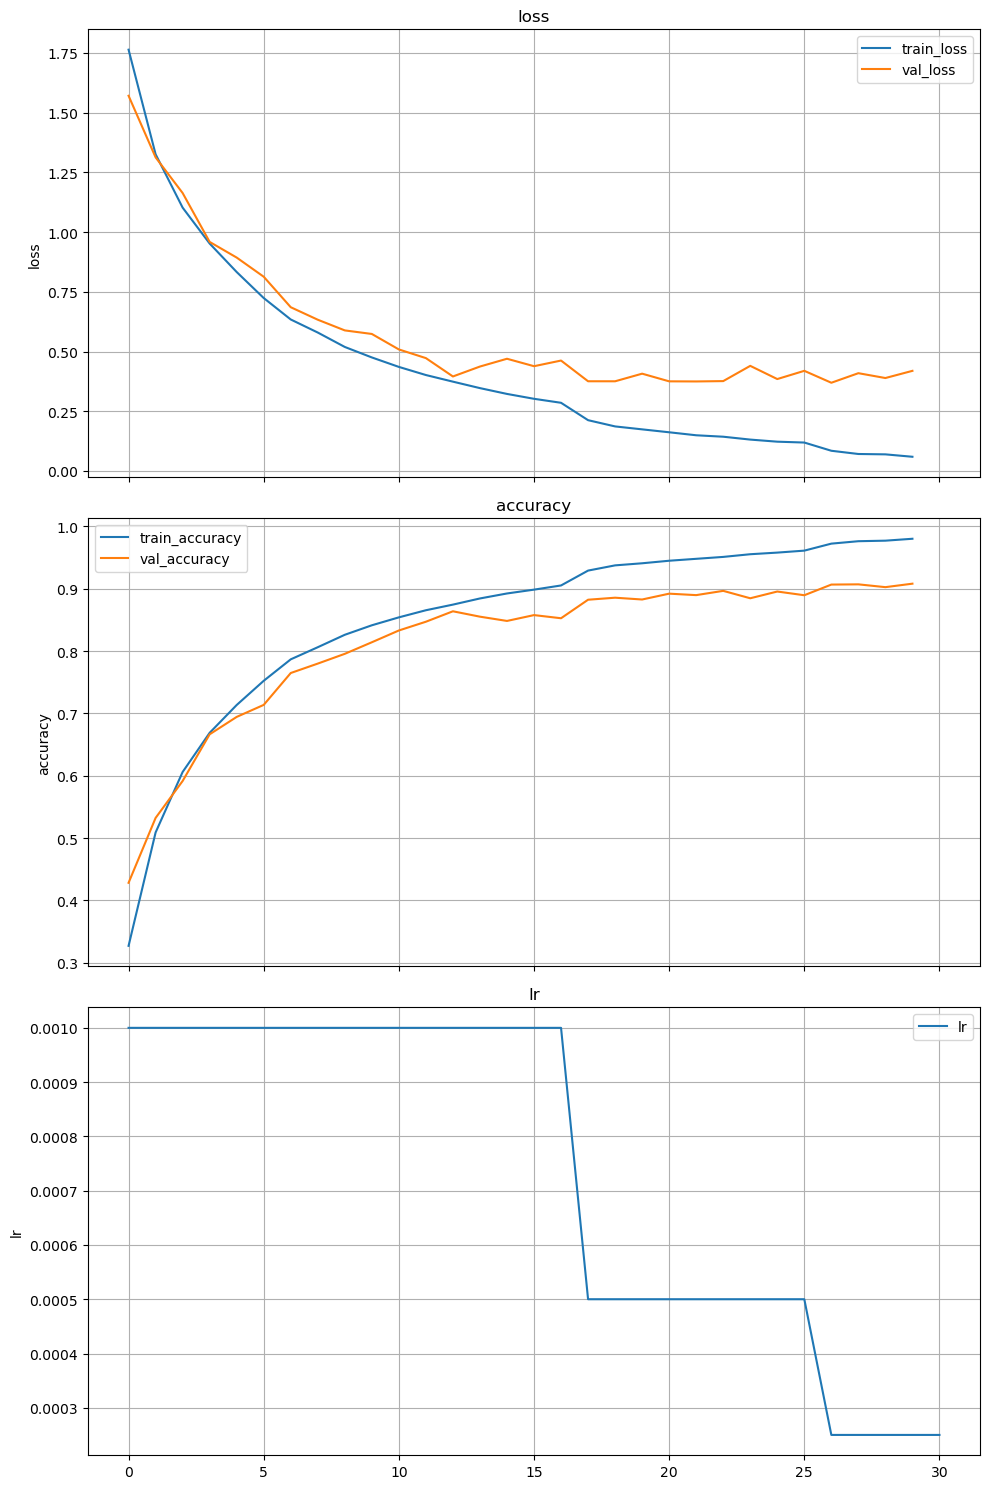

In [13]:
################ TEACHER ################ (res34)

res_layers_teacher = []
depth = 34
blocks_per_stage = [3, 4, 6, 3]
channels = [64, 128, 256, 512]
input_shape = (3, 32, 32)

for stage, (n_blocks, out_channels) in enumerate(zip(blocks_per_stage, channels)):
    for block_idx in range(n_blocks):
        stride = 2 if block_idx == 0 and stage > 0 else 1
        layer_config = {
            "out_channels": out_channels,
            "stride": stride,
            "dropout": 0.0,
            "pool": None
        }
        res_layers_teacher.append(layer_config)

teacher = ResCNN(
    input_shape = input_shape,
    res_layers = res_layers_teacher,
    block_type = BasicBlock,
    base_width = 64,
    norm_layer = nn.BatchNorm2d
)

output_size = teacher.get_output_size()
mlp_tail = MLP( #should i put softmax as act func? probably yes
    layer_sizes = [output_size, 512, 10],
    act_funcs = [nn.ReLU, None],
    dropouts = [0.5, 0.0],
    use_bias = True
)
teacher.attach_mlp(mlp_tail)

optimizer = torch.optim.Adam(teacher.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = patience)

pipeline = SLTrainingPipeline(
    model = teacher,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'teacher',
    log_dir = log_dir,
    checkpoint_dir = "." + checkpoints_dir,
    callbacks = callbacks
)

#history = pipeline.fit(epochs = n_epochs, train_loader = train, val_loader = val, verbose = False)
pipeline.load()

pipeline.plot()
#we just use evaluation to compute soft_labels thats why test_loader is train_loader
pipeline.evaluate(test_loader = train, verbose = False)

soft_labels = pipeline.get_callbacks_data()["soft_labels"]

/home/roccotescaro/repo/university/master/deep_learning_app/LAB/BaseTrainingPipeline.py:213: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  states = torch.load(file_path, map

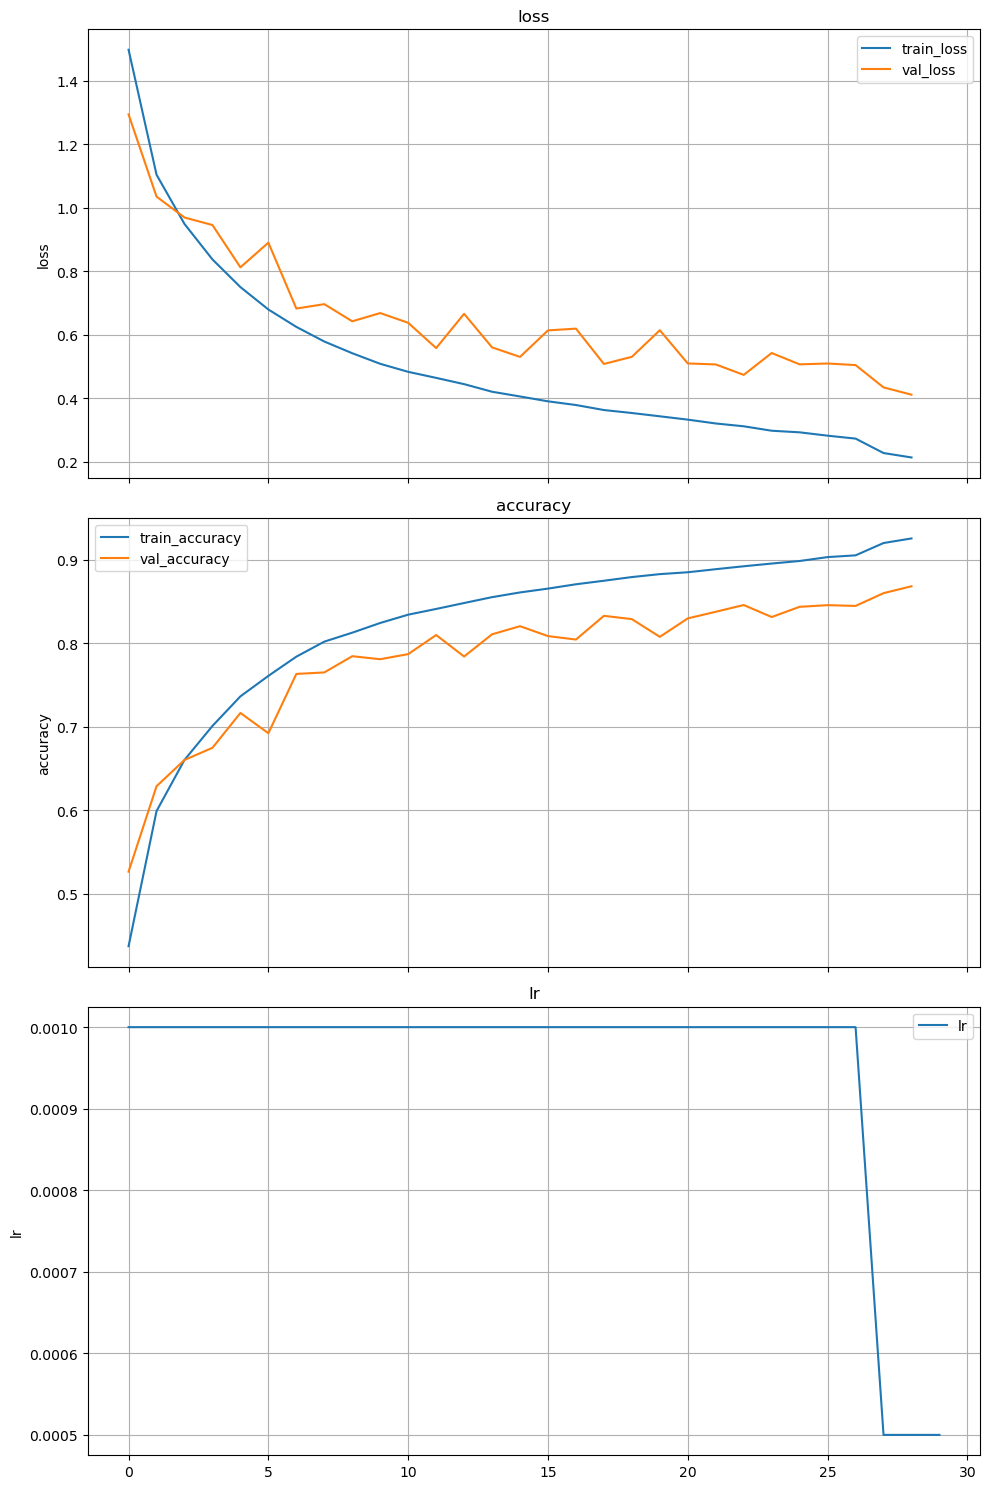

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'accuracy'}, ylabel='accuracy'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [ ]:
################ STUDENT ################ (res8)

res_layers_student = []
blocks_per_stage = [1, 2, 1]#2, 1]
channels = [32, 64, 128]#, 256]

for stage, (n_blocks, out_channels) in enumerate(zip(blocks_per_stage, channels)):
    for block_idx in range(n_blocks):
        stride = 2 if block_idx == 0 and stage > 0 else 1
        layer_config = {
            "out_channels": out_channels,
            "stride": stride,
            "dropout": 0.0,
            "pool": None
        }
        res_layers_student.append(layer_config)

student = ResCNN(
    input_shape = input_shape,
    res_layers = res_layers_student,
    block_type = BasicBlock,
    base_width = 64,
    norm_layer = nn.BatchNorm2d
)

output_size = student.get_output_size()
mlp_tail = MLP(
    layer_sizes = [output_size, 256, 10],
    act_funcs = [nn.ReLU, None],
    dropouts = [0.3, 0.0],
    use_bias = True
)
student.attach_mlp(mlp_tail)

optimizer = torch.optim.Adam(student.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = patience)

pipeline_student = SLTrainingPipeline(
    model = student,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'student',
    log_dir = log_dir,
    checkpoint_dir = "."+checkpoints_dir
)

#history_student = pipeline_student.fit(
#    epochs = n_epochs,
#    train_loader = train,
#    val_loader = val,
#    verbose = False
#)

pipeline_student.load()

pipeline_student.plot()

In [ ]:
checkpoints_dir
)

#history_student = pipeline_student.fit(
#    epochs = n_epochs,
#    train_loader = train,
#    val_loader = val,
#    verbose = False
#)

pipeline_student.load()

pipeline_student.plot()

In [14]:
############### DISTILLATION LOADER ################

class DistillationDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, soft_labels):

        self.original_dataset = original_dataset

        #suppose soft_labels a numpy array
        self.soft_labels = torch.from_numpy(soft_labels).float()
        
        assert len(self.original_dataset) == len(self.soft_labels), "Length mismatch between original dataset and soft labels."
        
    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        X, hard_label = self.original_dataset[idx]
        soft_label = self.soft_labels[idx]
        return X, (hard_label, soft_label)

In [15]:
############# DISTILLATION CRITERION ##############

import torch.nn.functional as F

class DistillationLoss(nn.Module):
    def __init__(self, temperature, alpha, base_criterion = nn.CrossEntropyLoss()):
        super().__init__()
        
        self.base_criterion = base_criterion
        self.temperature = temperature
        self.alpha = alpha

        self.kl_div_loss = nn.KLDivLoss(reduction = 'batchmean')

    def forward(self, y, targets):
        if not isinstance(targets, tuple) or len(targets) != 2:
            loss = self.base_criterion(y, targets)
            return loss

        hard, soft = targets

        loss_hard = self.base_criterion(y, hard)

        p = F.log_softmax(y/self.temperature, dim = 1)
        q = F.softmax(soft/self.temperature, dim = 1)

        loss_soft = self.kl_div_loss(p, q) * (self.temperature ** 2)

        loss = self.alpha * loss_hard + (1 - self.alpha) * loss_soft
        return loss

In [16]:
############# DISTILLATION METRICS ##############

def distillation_accuracy(logits, targets):
    if isinstance(targets, (list, tuple)):
        hard_labels = targets[0]  # Extract hard labels from the tuple
    else:
        hard_labels = targets

    if not isinstance(hard_labels, torch.Tensor):
        return 0.0

    _, predicted = torch.max(logits.data, 1) # Or use torch.max(logits, 1)

    return (predicted == hard_labels).float().mean().item()

metrics = {"accuracy": distillation_accuracy}

  7%|▋         | 2/30 [05:19<1:14:28, 159.59s/it]


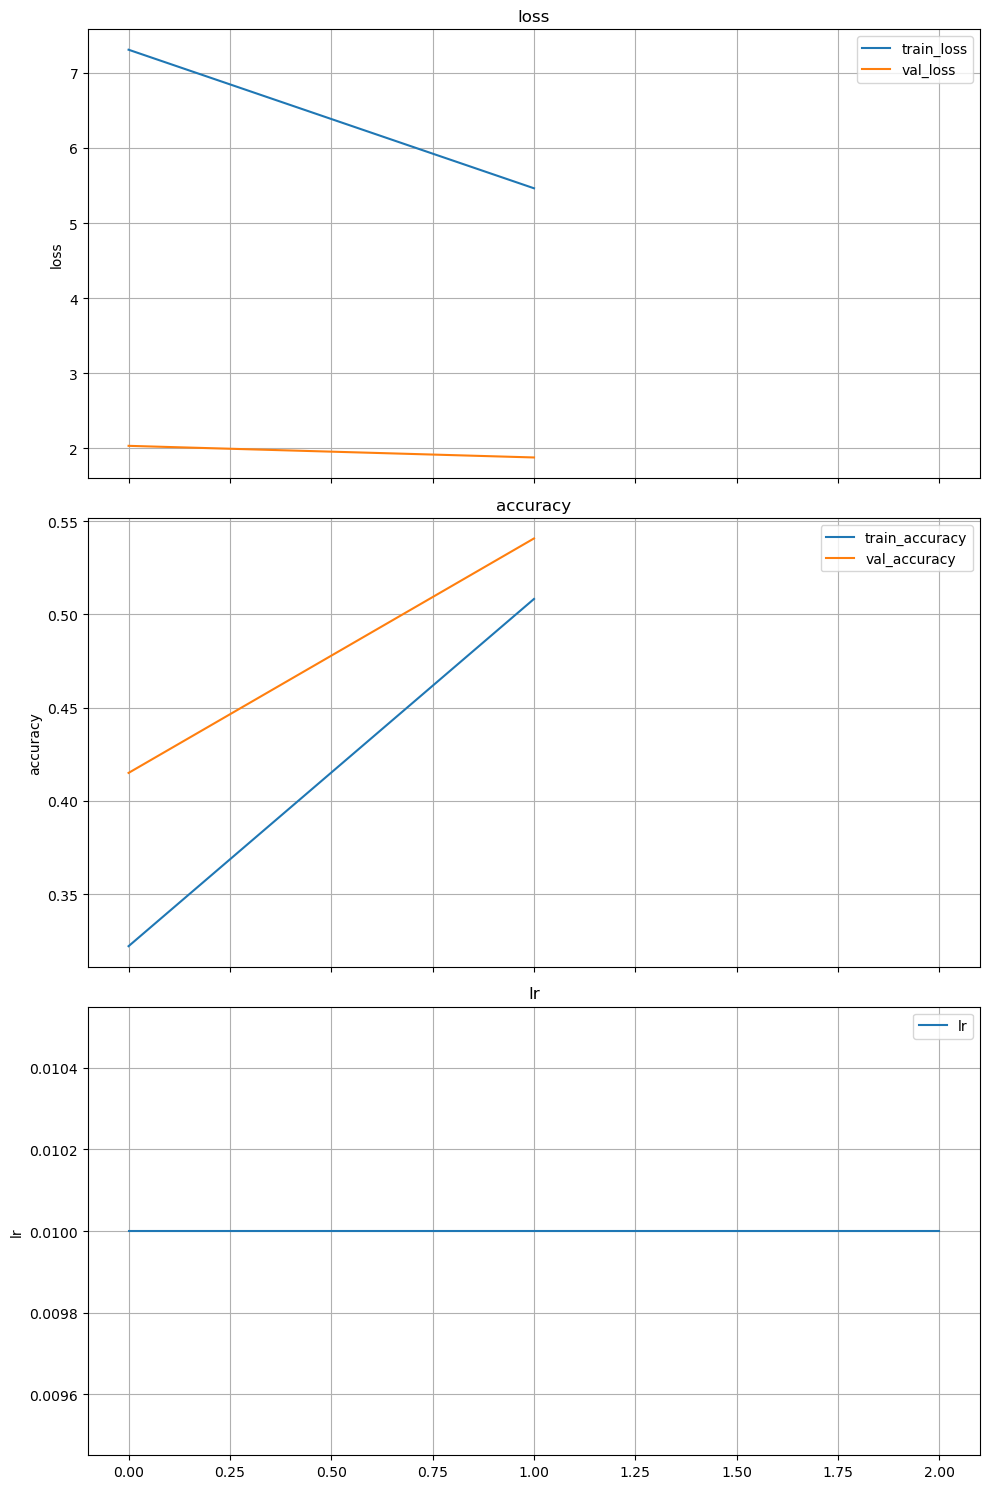

(<Figure size 1000x1500 with 3 Axes>,
 array([<Axes: title={'center': 'loss'}, ylabel='loss'>,
        <Axes: title={'center': 'accuracy'}, ylabel='accuracy'>,
        <Axes: title={'center': 'lr'}, ylabel='lr'>], dtype=object))

In [17]:
################ STUDENT AFTER LECTURES ################

soft_labels_tensor = torch.cat(soft_labels, dim = 0)
soft_labels_numpy = soft_labels_tensor.numpy()

train_dataset = DistillationDataset(train_dataset, soft_labels_numpy)
train = DataLoader(train_dataset, batch_size = batch_size, shuffle = False)

temperature = 4.0
alpha = 0.7
distill_criterion = DistillationLoss(temperature = temperature, alpha = alpha)

lr = 10 * lr #paper says to work with higer lr since we have more meaningful labels

res_layers_student = []
blocks_per_stage = [1, 2, 1]#2, 1]
channels = [32, 64, 128]#, 256]

for stage, (n_blocks, out_channels) in enumerate(zip(blocks_per_stage, channels)):
    for block_idx in range(n_blocks):
        stride = 2 if block_idx == 0 and stage > 0 else 1
        layer_config = {
            "out_channels": out_channels,
            "stride": stride,
            "dropout": 0.0,
            "pool": None
        }
        res_layers_student.append(layer_config)

student = ResCNN(
    input_shape = input_shape,
    res_layers = res_layers_student,
    block_type = BasicBlock,
    base_width = 64,
    norm_layer = nn.BatchNorm2d
)

output_size = student.get_output_size()
mlp_tail = MLP(
    layer_sizes = [output_size, 256, 10],
    act_funcs = [nn.ReLU, None],
    dropouts = [0.3, 0.0],
    use_bias = True
)
student.attach_mlp(mlp_tail)

optimizer = torch.optim.Adam(student.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode = 'min', factor = 0.5, patience = 3)

pipeline_student = SLTrainingPipeline(
    model = student,
    criterion = distill_criterion,
    optimizer = optimizer,
    lr_scheduler = scheduler,
    metrics = metrics,
    device = device,
    run_id = 'student_after_lectures',
    log_dir = log_dir,
    checkpoint_dir = checkpoints_dir
)

history_student = pipeline_student.fit(
    epochs = n_epochs,
    train_loader = train,
    val_loader = val,
    verbose = False
)

#pipeline_student.load()

pipeline_student.plot()

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.3 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your CNN implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes. Try your implementation out using a pre-trained ResNet-18 model and some images from the [Imagenette](https://pytorch.org/vision/0.20/generated/torchvision.datasets.Imagenette.html#torchvision.datasets.Imagenette) dataset -- I suggest you start with the low resolution version of images at 160px.

In [ ]:
# Your code here.